In [6]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [11]:
from typing import Dict, TypedDict, List, Annotated, Literal
import os
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate

# Define the state for our graph
class AgentState(TypedDict):
    topic: str
    messages: list
    draft: str
    reflection: str
    iteration: int
    max_iterations: int
    final_output: str

# Initialize our LLM - Fix: properly initialize the LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
llm2 = ChatOpenAI(model="gpt-4o", temperature=0.7)

# Define the generator node
def generate_content(state: AgentState) -> AgentState:
    """Generate content based on the topic and reflection"""

    iteration = state["iteration"]
    topic = state["topic"]
    messages = state["messages"]
    reflection = state.get("reflection", "")

    if iteration == 0:
        # First draft, no reflection yet
        generator_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful content creator. Generate a short draft on the given topic."),
            ("human", f"Please create content about: {topic}")
        ])
    else:
        # Use reflection to improve
        previous_draft = state['draft']
        generator_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful content creator. Improve your draft based on the reflection."),
            ("human", f"Topic: {topic}\n\nPrevious draft: {previous_draft}\n\nReflection: {reflection}\n\nPlease create an improved version.")
        ])

    # Fix: invoke with empty dict since we're using f-strings in the template
    response = llm.invoke(generator_prompt.format_messages())

    # Update state with the generated draft
    return {
        **state,
        "draft": response.content,
        "messages": messages + [{"role": "assistant", "content": f"[Draft {iteration+1}]: {response.content}"}]
    }

# Define the reflection node
def reflect_on_content(state: AgentState) -> AgentState:
    """Reflect on the quality of the generated content and suggest improvements"""

    draft = state["draft"]
    topic = state["topic"]

    reflection_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a critical editor. Carefully analyze the draft content and provide specific feedback for improvement."),
        ("human", f"Review this content about '{topic}':\n\n{draft}\n\nProvide specific feedback on how to improve this content. Focus on clarity, accuracy, engagement, and relevance.")
    ])

    # Fix: invoke with empty dict since we're using f-strings in the template
    response = llm2.invoke(reflection_prompt.format_messages())

    # Update state with reflection
    return {
        **state,
        "reflection": response.content,
        "messages": state["messages"] + [{"role": "assistant", "content": f"[Reflection]: {response.content}"}],
        "iteration": state["iteration"] + 1
    }

# Define the finalization node
def finalize_content(state: AgentState) -> AgentState:
    """Finalize the content based on the last draft"""

    draft = state["draft"]
    topic = state["topic"]

    final_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a skilled editor. Polish the provided draft into a final version."),
        ("human", f"Please finalize this content about '{topic}':\n\n{draft}\n\nCreate a polished final version.")
    ])

    # Fix: invoke with empty dict since we're using f-strings in the template
    response = llm.invoke(final_prompt.format_messages())

    # Update state with final output
    return {
        **state,
        "final_output": response.content,
        "messages": state["messages"] + [{"role": "assistant", "content": f"[Final Content]: {response.content}"}]
    }

# Define the decision function to determine when to stop iterations
def should_continue(state: AgentState) -> Literal["reflect", "finalize"]:
    """Decide whether to continue iterating or finalize the content"""
    if state["iteration"] >= state["max_iterations"]:
        return "finalize"
    else:
        return "reflect"

# Build the graph
def build_content_graph():
    # Initialize the graph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("generate", generate_content)
    workflow.add_node("reflect", reflect_on_content)
    workflow.add_node("finalize", finalize_content)

    # Add edges
    workflow.add_edge(START , "generate")
    workflow.add_conditional_edges(
        "generate",
        should_continue,
        {
            "reflect": "reflect",
            "finalize": "finalize"
        }
    )
    workflow.add_edge("reflect", "generate")
    workflow.add_edge("finalize", END)

    # Set the entry point
    workflow.set_entry_point("generate")

    return workflow.compile()

# Create the graph
content_graph = build_content_graph()



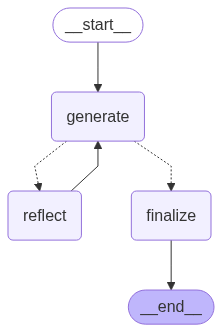

In [13]:
from IPython.display import Markdown, display, Image

display(Image(content_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# Test the graph
result = content_graph.invoke({
    "topic": "Agentic AI workshop",
    "messages": [],
    "draft": "",
    "reflection": "",
    "iteration": 0,
    "max_iterations": 2,
    "final_output": ""
})

print("Final Output:")
print(result["final_output"])
print("\nAll Messages:")
for msg in result["messages"]:
    print(f"{msg['role']}: {msg['content']}")

Final Output:
Title: Unveiling Agentic AI: An Interactive Workshop Experience

Introduction:
Step into the world of Agentic AI, a cutting-edge frontier in artificial intelligence where systems operate autonomously, making decisions independently. Imagine an immersive workshop where you can delve into the vast potential and ethical considerations of this transformative field, exploring its applications and impacts in depth.

Clarify Terminology and Concepts:
Agentic AI refers to autonomous systems that can make decisions and act independently, shaping the future of technology and society.

Workshop Objectives:
- Gain a comprehensive understanding of the core principles and frameworks driving Agentic AI.
- Analyze real-world instances to assess the societal impacts and ethical challenges posed by autonomous AI systems.
- Participate in interactive discussions and collaborate with industry experts to generate innovative solutions.
- Tailored for AI developers, ethicists, and business lead

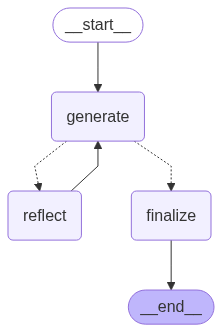

In [ ]:
Final Output:
Title: Unleashing the Power of Agentic AI: An Interactive Workshop Experience

Introduction:
Welcome to the Agentic AI workshop, a cutting-edge event poised to revolutionize your perception of artificial intelligence. Explore the future of AI through agentic systems that not only analyze data but also autonomously make decisions. This workshop serves as your gateway to unlocking the vast potential of autonomous AI and its transformative impact on society. Prepare for a journey where innovation converges with endless possibilities.

Content:
The Agentic AI workshop unites industry experts, researchers, and enthusiasts for an in-depth exploration of the capabilities, applications, and ethical considerations surrounding autonomous AI systems. Through interactive activities, lively discussions, and insightful presentations, you will witness firsthand how agentic AI is reshaping industries in domains like healthcare, finance, and transportation.

Delve into real-world case studies that highlight the revolutionary impact of agentic AI, offering valuable perspectives on the challenges and prospects of deploying autonomous systems in complex environments. Engage with peers and experts to cultivate collaboration, exchange knowledge, and fuel innovation in the realm of autonomous AI technology.

Language and Tone:
Immerse yourself in the dynamic world of agentic AI, where innovation and possibility converge to shape the future of intelligent systems. Embark on a journey of discovery as we collectively explore the groundbreaking advancements in autonomous AI technology. Let’s unlock the potential of agentic AI and pave the way for a future defined by innovation and progress.

Call to Action:
Are you ready to be at the forefront of the AI revolution? Join us at the Agentic AI workshop to gain invaluable insights, establish meaningful connections, and uncover the transformative power of autonomous AI technology. Seize this opportunity to deepen your understanding of agentic AI and its implications for the future. Register now to secure your spot at this immersive event and contribute to shaping the trajectory of autonomous systems.

Conclusion:
The Agentic AI workshop transcends being a mere event; it offers a transformative voyage into the realm of artificial intelligence. Register today to participate in this captivating exploration of agentic AI and witness firsthand the impact of intelligent systems in action. Together, let’s unlock the boundless possibilities that agentic AI presents and mold the future of autonomous technology.

All Messages:

# [Draft 1]
assistant: [Draft 1]: Title: Exploring the Potential of Agentic AI: A Workshop

Artificial Intelligence has evolved significantly in recent years, with the emergence of agentic AI representing a groundbreaking development. Agentic AI refers to systems that not only process data and make decisions but also possess a level of autonomy and agency in their actions. To delve deeper into this fascinating field, an Agentic AI workshop can be a valuable platform for learning and collaboration.

The Agentic AI workshop aims to bring together industry experts, researchers, and enthusiasts to explore the capabilities, applications, and ethical implications of autonomous AI systems. Participants will have the opportunity to engage in hands-on activities, discussions, and presentations that showcase the latest advancements in agentic AI technology.

Through interactive sessions and real-world case studies, attendees will gain insights into how agentic AI is revolutionizing various industries, such as healthcare, finance, and transportation. They will also have the chance to discuss the challenges and opportunities associated with deploying autonomous AI systems in complex environments.

Furthermore, the workshop will foster networking opportunities and collaborations among participants, encouraging knowledge sharing and innovation in the field of agentic AI. By connecting with like-minded individuals and experts, attendees can expand their understanding of autonomous AI technology and its potential impact on society.

Overall, the Agentic AI workshop serves as a valuable platform for individuals interested in exploring the frontiers of artificial intelligence and shaping the future of autonomous systems. Join us in this exciting journey of discovery and innovation in the realm of agentic AI.
assistant: [Reflection]: The content about the 'Agentic AI workshop' is well-structured and informative, but there are areas where it can be improved for better clarity, accuracy, engagement, and relevance. Here are some specific feedback points for enhancement:

1. **Title:** The title is clear and informative. It effectively communicates the focus of the workshop. No changes needed here.

2. **Introduction:**
   - **Clarity:** The introduction effectively introduces the topic of agentic AI but could benefit from a more engaging opening to capture the reader's interest.
   - **Engagement:** Consider starting with a compelling statistic, anecdote, or question to draw readers in.

3. **Content:**
   - **Accuracy:** While the content provides a good overview of agentic AI, consider adding specific examples or case studies to illustrate how these systems work in practice. This can help readers better understand the concept.
   - **Relevance:** Ensure that the content remains focused on the workshop itself. Avoid overly generic statements about AI and instead emphasize what attendees can expect to learn and gain from participating.

4. **Language and Tone:**
   - **Engagement:** Use more dynamic language to make the content more engaging. For example, instead of "fascinating field," consider more vivid language like "cutting-edge field" or "thriving industry."
   - **Clarity:** Avoid overly complex language or jargon that may alienate readers who are not familiar with AI terminologies. Strive for a balance between technical accuracy and accessibility.

5. **Call to Action:**
   - **Engagement:** Enhance the call to action at the end of the content to encourage readers to take concrete steps, such as registering for the workshop or accessing more resources on agentic AI.
   - **Relevance:** Clearly state the benefits of attending the workshop and how it can help participants advance their knowledge and skills in the field of AI.

6. **Overall Structure:**
   - **Clarity:** Ensure a logical flow of information from introduction to conclusion. Each section should build upon the previous one to guide readers through the content seamlessly.
   - **Engagement:** Consider breaking up the content into shorter paragraphs for easier readability. Use subheadings to organize information and make key points stand out.

By implementing these feedback points, the content about the 'Agentic AI workshop' can be enhanced to better inform, engage, and inspire readers to participate in the workshop and explore the exciting world of agentic AI.
# [Draft 2]
assistant: [Draft 2]: Title: Unleashing the Power of Agentic AI: An Interactive Workshop Experience

Introduction:
Did you know that the future of Artificial Intelligence is taking a bold step forward with the rise of agentic AI? Imagine systems not just analyzing data but making decisions autonomously. This groundbreaking technology is reshaping industries and pushing the boundaries of what we thought possible. Welcome to the Agentic AI workshop, where we invite you to dive deep into this transformative field and unlock its potential.

Content:
Join us at the Agentic AI workshop, where industry experts, researchers, and enthusiasts converge to explore the capabilities, applications, and ethical considerations surrounding autonomous AI systems. Through hands-on activities, lively discussions, and cutting-edge presentations, you'll witness firsthand the evolution of agentic AI technology and its impact across various sectors, from healthcare to finance and transportation.

Delve into real-world case studies that showcase how agentic AI is revolutionizing industries, offering insights into the challenges and opportunities that come with deploying autonomous systems in complex environments. Engage with like-minded individuals and experts to foster collaboration, share knowledge, and drive innovation in the realm of agentic AI.

Language and Tone:
Immerse yourself in the world of agentic AI, a dynamic and ever-evolving field that promises to shape the future of autonomous systems. Discover how these intelligent systems are propelling us into a new era of innovation and possibility. Let's explore together the limitless potential of agentic AI and its profound impact on society.

Call to Action:
Ready to embark on a journey of discovery and innovation in the realm of agentic AI? Join us at the workshop to gain invaluable insights, forge meaningful connections, and be at the forefront of the AI revolution. Don't miss this opportunity to be part of a transformative experience that will expand your understanding of autonomous AI technology and its implications for the future.

Conclusion:
The Agentic AI workshop is your gateway to exploring the frontiers of artificial intelligence and shaping the future of autonomous systems. Register now to be part of this exciting exploration of agentic AI and witness firsthand the power of intelligent systems in action. Let's embark on this transformative journey together and unlock the infinite possibilities that agentic AI has to offer.

By incorporating these enhancements, the content about the 'Agentic AI workshop' is now more engaging, informative, and compelling, encouraging readers to participate in this immersive experience and discover the potential of agentic AI.
assistant: [Reflection]: Overall, the content about the 'Agentic AI workshop' is well-structured and engaging, offering a compelling overview of the event. To enhance the content further, here are some specific feedback points for improvement:

1. **Clarity and Specificity**:
   - While the introduction and content provide a good overview of the workshop, consider adding more specific details about the event such as the date, venue, speakers, and agenda. This will help potential participants understand what to expect and why they should attend.

2. **Balance Enthusiasm with Information**:
   - The language and tone used in the content are enthusiastic and engaging. However, ensure that the excitement is balanced with concrete information about the workshop's objectives, sessions, and key takeaways. This will help set clear expectations for attendees.

3. **Highlight Interactive Elements**:
   - Emphasize the interactive nature of the workshop by providing specific examples of hands-on activities, group discussions, or practical exercises that participants will engage in. This will help differentiate the event from passive lectures or presentations.

4. **Ethical Considerations**:
   - While the content briefly mentions ethical considerations, consider expanding on this aspect to demonstrate the workshop's commitment to responsible AI development and deployment. Highlighting discussions around ethics can attract participants interested in this critical aspect of AI.

5. **Include Testimonials or Past Success Stories**:
   - To add credibility and showcase the value of the workshop, consider including testimonials from past participants or success stories from previous editions. This can help build trust and demonstrate the practical benefits of attending the event.

6. **Incorporate Visual Elements**:
   - To enhance engagement, consider incorporating visuals such as images, infographics, or videos related to agentic AI to break up the text and make the content more visually appealing. Visual elements can help illustrate complex concepts and capture the audience's attention.

7. **Encourage Early Registration**:
   - In the call to action, consider adding a sense of urgency by mentioning limited spots available or early bird discounts for those who register promptly. This can motivate readers to take immediate action and secure their spot at the workshop.

8. **Proofreading and Editing**:
   - Lastly, ensure that the content is free from any grammatical errors, typos, or inconsistencies. A thorough proofreading session can help polish the content and maintain a professional tone throughout.

By addressing these feedback points, you can further enhance the content about the 'Agentic AI workshop' and effectively communicate the value of the event to potential participants.
assistant: [Draft 3]: Title: Unleashing the Power of Agentic AI: An Interactive Workshop Experience

Introduction:
Join us at the Agentic AI workshop, a cutting-edge event that is set to transform your understanding of artificial intelligence. Discover the future of AI with agentic systems that not only analyze data but also make decisions independently. This workshop is your gateway to exploring the limitless potential of autonomous AI and its profound impact on society. Welcome to a transformative experience where innovation meets possibility.

Content:
The Agentic AI workshop brings together industry experts, researchers, and enthusiasts to delve deep into the capabilities, applications, and ethical considerations of autonomous AI systems. Through hands-on activities, dynamic discussions, and thought-provoking presentations, you will witness firsthand how agentic AI is revolutionizing industries across sectors such as healthcare, finance, and transportation.

Explore real-world case studies that showcase the transformative power of agentic AI, offering insights into the challenges and opportunities of deploying autonomous systems in complex environments. Engage with like-minded individuals and experts to foster collaboration, share knowledge, and drive innovation in the realm of autonomous AI technology.

Language and Tone:
Immerse yourself in the dynamic world of agentic AI, where innovation and possibility collide to shape the future of intelligent systems. Embark on a journey of discovery as we explore together the groundbreaking advancements in autonomous AI technology. Let's unlock the potential of agentic AI and pave the way for a future defined by innovation and progress.

Call to Action:
Ready to be at the forefront of the AI revolution? Join us at the Agentic AI workshop to gain invaluable insights, forge meaningful connections, and discover the transformative power of autonomous AI technology. Don't miss this opportunity to expand your understanding of agentic AI and its implications for the future. Register now to secure your spot at this immersive event and be part of shaping the future of autonomous systems.

Conclusion:
The Agentic AI workshop is not just an event; it's a transformative journey into the realm of artificial intelligence. Register today to be part of this exciting exploration of agentic AI and witness firsthand the impact of intelligent systems in action. Together, let's unlock the infinite possibilities that agentic AI has to offer and shape the future of autonomous technology.

By incorporating these improvements, the content about the 'Agentic AI workshop' is now more engaging, informative, and compelling, providing a clearer picture of the event and encouraging readers to participate in this immersive experience.
assistant: [Final Content]: Title: Unleashing the Power of Agentic AI: An Interactive Workshop Experience

Introduction:
Welcome to the Agentic AI workshop, a cutting-edge event poised to revolutionize your perception of artificial intelligence. Explore the future of AI through agentic systems that not only analyze data but also autonomously make decisions. This workshop serves as your gateway to unlocking the vast potential of autonomous AI and its transformative impact on society. Prepare for a journey where innovation converges with endless possibilities.

Content:
The Agentic AI workshop unites industry experts, researchers, and enthusiasts for an in-depth exploration of the capabilities, applications, and ethical considerations surrounding autonomous AI systems. Through interactive activities, lively discussions, and insightful presentations, you will witness firsthand how agentic AI is reshaping industries in domains like healthcare, finance, and transportation.

Delve into real-world case studies that highlight the revolutionary impact of agentic AI, offering valuable perspectives on the challenges and prospects of deploying autonomous systems in complex environments. Engage with peers and experts to cultivate collaboration, exchange knowledge, and fuel innovation in the realm of autonomous AI technology.

Language and Tone:
Immerse yourself in the dynamic world of agentic AI, where innovation and possibility converge to shape the future of intelligent systems. Embark on a journey of discovery as we collectively explore the groundbreaking advancements in autonomous AI technology. Let’s unlock the potential of agentic AI and pave the way for a future defined by innovation and progress.

Call to Action:
Are you ready to be at the forefront of the AI revolution? Join us at the Agentic AI workshop to gain invaluable insights, establish meaningful connections, and uncover the transformative power of autonomous AI technology. Seize this opportunity to deepen your understanding of agentic AI and its implications for the future. Register now to secure your spot at this immersive event and contribute to shaping the trajectory of autonomous systems.

Conclusion:
The Agentic AI workshop transcends being a mere event; it offers a transformative voyage into the realm of artificial intelligence. Register today to participate in this captivating exploration of agentic AI and witness firsthand the impact of intelligent systems in action. Together, let’s unlock the boundless possibilities that agentic AI presents and mold the future of autonomous technology.

SyntaxError: invalid character '’' (U+2019) (1661964878.py, line 13)